In [9]:
import os
from typing import Sequence
from tqdm import tqdm
from matplotlib import pyplot as plt
from torch.utils.tensorboard.writer import SummaryWriter
# from torch.profiler import profile, record_function, ProfilerActivity
import torch
from model2 import GVAE
from loss import reconstruction_loss, kl_loss
from dataset1 import SketchDataset
from torch.utils.data import DataLoader, Subset, random_split, TensorDataset
os.chdir('SketchGraphs/')
import sketchgraphs.data as datalib
os.chdir('../')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
class GPUTrainer:
    def __init__(
            self,
            learning_rate: float,
            gpu_id: int,
            num_epochs: int,
            experiment_string: str,
            batch_size: int
            ):
        print("---Loading Model on GPU---")
        self.model = GVAE(gpu_id)
        print(f"---Finished Loading Model on GPU: {torch.cuda.max_memory_allocated(gpu_id) // 1e6}MB---")
        print("---Loading Dataset into Memory---")
        dataset = SketchDataset(root="data/")
        dataset = TensorDataset(dataset.nodes, dataset.edges, dataset.node_params_mask)
        print(f"---Finished Loading Dataset into Memory {torch.cuda.max_memory_allocated(gpu_id) // 1e6}MB---")
        train_set, validate_set, test_set = random_split(dataset = dataset, lengths = [0.8, 0.1, 0.1])
        self.train_loader = DataLoader(dataset = train_set, 
                                       batch_size = batch_size, 
                                       shuffle = True, 
                                       pin_memory = True
                                      )
        self.validate_loader = DataLoader(dataset = validate_set, 
                                          batch_size = batch_size, 
                                          shuffle = False, 
                                          pin_memory = True
                                         )
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr = learning_rate)
        # self.optimizer = ZeroRedundancyOptimizer(self.model.parameters(),
        #                                          optimizer_class = torch.optim.Adam,
        #                                          lr = learning_rate
        #                                         )
        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(self.optimizer, T_0 = num_epochs//5, T_mult = 1, eta_min = .000001)
        
        self.gpu_id = gpu_id
        self.writer = SummaryWriter(f'runs/{experiment_string}')
        self.num_epochs = num_epochs

        self.global_step = 0
        self.curr_epoch = 0
        self.min_validation_loss = float('inf')

    
    def train_batch(self, nodes : torch.Tensor, edges : torch.Tensor, params_mask : torch.Tensor) -> float:
        self.optimizer.zero_grad()

        nodes = nodes.to(self.gpu_id)
        edges = edges.to(self.gpu_id)
        params_mask = params_mask.to(self.gpu_id)

        pred_nodes, pred_edges, means, logvars = self.model(nodes, edges)

        # assert pred_nodes.isfinite().all(), "Model output for nodes has non finite values"
        # assert pred_edges.isfinite().all(), "Model output for edges has non finite values"
        # assert means.isfinite().all(),      "Model output for means has non finite values"
        # assert logvars.isfinite().all(),    "Model output for logvars has non finite values"

        loss_dict = {} # dictionary to record loss values 
        loss = reconstruction_loss(pred_nodes, pred_edges, nodes, edges, params_mask, loss_dict) + kl_loss(means, logvars, loss_dict)

        # assert loss.isfinite().all(), "Loss is non finite value"

        loss.backward()
        self.optimizer.step()

        loss_dict["total loss"] = loss.item()
        return loss_dict
    
    def train_epoch(self):
        pbar = tqdm(self.train_loader) if self.gpu_id == 0 else self.train_loader
        for nodes, edges, params_mask in pbar:
            iter_loss_dict = self.train_batch(nodes, edges, params_mask)
            break

            self.global_step += 1

            if (self.global_step % 200 == 1):
                if self.gpu_id == 0: self.plot_loss(iter_loss_dict) # self.writer.add_scalar("Training Loss", iter_loss, self.global_step)

            iter_loss = iter_loss_dict["total loss"]
            if self.gpu_id == 0: pbar.set_description(f"Training Epoch {self.curr_epoch} Iter Loss: {iter_loss}")
    
    def plot_loss(self, loss_dict):
        self.writer.add_scalar("Training/Total_Loss", loss_dict["total loss"], self.global_step)
        self.writer.add_scalar("Training/Node_Loss", loss_dict["node loss"], self.global_step)
        self.writer.add_scalar("Training/Node_BCE", loss_dict["node bce"], self.global_step)
        self.writer.add_scalar("Training/Node_Cross", loss_dict["node cross"], self.global_step)
        self.writer.add_scalar("Training/Node_MSE", loss_dict["node mse"], self.global_step)
        self.writer.add_scalar("Training/Edge_Loss", loss_dict["edge loss"], self.global_step)
        self.writer.add_scalar("Training/Edge_sub_a", loss_dict["edge sub_a cross"], self.global_step)
        self.writer.add_scalar("Training/Edge_sub_b", loss_dict["edge sub_b cross"], self.global_step)
        self.writer.add_scalar("Training/Edge_Cross", loss_dict["edge cross"], self.global_step)
        self.writer.add_scalar("Training/KLD", loss_dict["kld"], self.global_step)
    
    @torch.no_grad()
    def validate(self):
        pbar = tqdm(self.validate_loader)
        total_loss = 0
        for nodes, edges in pbar:
            nodes = nodes.to(self.gpu_id)
            edges = edges.to(self.gpu_id)

            pred_nodes, pred_edges, means, logvars = self.model(nodes, edges)

            loss = reconstruction_loss(pred_nodes, pred_edges, nodes, edges)
            loss += kl_loss(means, logvars)

            total_loss += loss

            assert loss.isfinite().all(), "Loss is non finite value"

            pbar.set_description(f"Validating Epoch {self.curr_epoch}  ")
        
        avg_loss = total_loss / len(pbar)
        self.writer.add_scalar("Validation Loss", avg_loss, self.curr_epoch)

        if avg_loss < self.min_validation_loss:
            self.min_validation_loss = avg_loss
            self.save_checkpoint()
            print("---Saved Model Checkpoint---")
        
        
        fig, axes = plt.subplots(nrows = 4, ncols = 2, figsize=(8, 16))
        fig.suptitle(f"Target (left) vs Preds (right) for epoch {self.curr_epoch}")
        for i in range(4):
            target_sketch = SketchDataset.preds_to_sketch(nodes[i].cpu(), edges[i].cpu())
            pred_sketch = SketchDataset.preds_to_sketch(pred_nodes[i].cpu(), pred_edges[i].cpu())
                
            datalib.render_sketch(target_sketch, axes[i, 0])
            datalib.render_sketch(pred_sketch, axes[i, 1])
            
        self.writer.add_figure(f"Epoch result visualization", fig, self.curr_epoch)
        plt.close()
                
    def train(self):
        self.global_step = 0
        self.curr_epoch = 0

        while (self.curr_epoch < self.num_epochs):
            self.model.train()
            self.train_epoch()
            self.model.eval()
            self.validate()
            self.curr_epoch += 1
            self.scheduler.step(self.curr_epoch)
            self.writer.add_scalar("Learning Rate", self.scheduler.get_last_lr(), self.curr_epoch)
            # print("Learning Rate: ", self.scheduler.get_last_lr())
    
    def save_checkpoint(self):
        checkpoint = self.model.state_dict()
        torch.save(checkpoint, "best_model_checkpoint.pth")

In [ ]:
trainer = GPUTrainer(learning_rate = 1e-4, 
                     gpu_id = 0, 
                     num_epochs = 40,
                     experiment_string = "test",
                     batch_size = 118
                    )

In [ ]:
trainer.train_epoch()

In [2]:
import torch
from diffusion_model import GD3PM
from loss import diffusion_loss
import importlib
import sys

In [19]:
importlib.reload(sys.modules["model3"])
from model3 import GVAE

In [6]:
model = GD3PM(device = 2)

In [ ]:
print(model.state_dict())

In [4]:
state_dict = torch.load(f"model_checkpoint_gd3pm_ddp_Adam_mse-25_kld-.001_24layers16heads256hidden.pth")

In [7]:
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k[7:] # remove 'module.' of dataparallel
    new_state_dict[name]=v

model.load_state_dict(new_state_dict)

<All keys matched successfully>

In [10]:
model.eval()
model.sample(1)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:2 and cpu! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

In [ ]:

optimizer = torch.optim.Adam(model.parameters(), lr = .001)

In [8]:
nodes = torch.randn(128, 24, 20)
edges = torch.randn(128, 24, 24, 17)

In [ ]:
print(torch.cuda.max_memory_allocated(0) / 1e6)

In [4]:
optimizer.zero_grad()

In [9]:
nodes = nodes.to(0)
edges = edges.to(0)

In [ ]:
model.eval()

In [11]:
pred_nodes, pred_edges, means, logvars = model(nodes, edges)

In [ ]:
pred_nodes[:,:,2]

In [ ]:
target_sketch = SketchDataset.preds_to_sketch(nodes[1].detach().cpu(), edges[1].detach().cpu())
pred_sketch0 = SketchDataset.preds_to_sketch(pred_nodes[0].detach().cpu(), pred_edges[0].detach().cpu())
pred_sketch1 = SketchDataset.preds_to_sketch(pred_nodes[1].detach().cpu(), pred_edges[1].detach().cpu())

In [ ]:
datalib.render_sketch(pred_sketch0)
print()

In [ ]:
datalib.render_sketch(pred_sketch1)
print()

In [7]:
loss = reconstruction_loss(pred_nodes, pred_edges, nodes, edges) + kl_loss(means, logvars)

TypeError: reconstruction_loss() missing 1 required positional argument: 'params_mask'

In [ ]:
loss.backward()

In [ ]:
optimizer.step()

In [ ]:
%matplotlib inline

In [ ]:
def visualize_graph(nodes, edges, filename):
    sketch = SketchDataset.preds_to_sketch(nodes, edges)
    seq = datalib.sketch_to_sequence(sketch)
    graph = datalib.pgvgraph_from_sequence(seq)
    datalib.render_graph(graph, f"{filename}.png")

# Render the graph visualization of the Sketch
nodes = torch.randn(24, 20)
edges = torch.randn(24, 24, 17)
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(16, 8))
fig.suptitle(f"Target (left) vs Preds (right) for epoch {0}")
visualize_graph(nodes.cpu(), edges.cpu(), "target_graph")
axes[0].imshow(plt.imread("target_graph.png"))
fig.show()
# self.writer.add_figure(f"Validation/Epoch_Graph_Visualization", fig, self.curr_epoch)
plt.close()

In [ ]:
dataset = SketchDataset(root="data/")

In [ ]:
# params_mask = SketchDataset.batched_params_mask(dataset.nodes)

In [ ]:
dataset..size()

In [ ]:
# params_mask.size()

In [ ]:
# torch.save(params_mask, "node_params_mask.pt")

In [ ]:
nodes = torch.randn(50, 24, 20)
edges = torch.randn(50, 24, 24, 17)
pred_nodes = torch.randn(50, 24, 20)
pred_edges = torch.randn(50, 24, 24, 17)
params_mask = torch.randn(50, 24, 14)

In [ ]:
reconstruction_loss(nodes, edges, pred_nodes, pred_edges, params_mask)

In [1]:
import os
from typing import Sequence
from tqdm import tqdm
from matplotlib import pyplot as plt
from torch.utils.tensorboard.writer import SummaryWriter
# from torch.profiler import profile, record_function, ProfilerActivity
import torch
from model2 import GVAE
from loss import reconstruction_loss, kl_loss
from dataset1 import SketchDataset
from torch.utils.data import DataLoader, Subset, random_split, TensorDataset
os.chdir('SketchGraphs/')
import sketchgraphs.data as datalib
from sketchgraphs.data import flat_array
from sketchgraphs.data._entity import Point, Line, Circle, Arc, EntityType
from sketchgraphs.data.sketch import Sketch
from sketchgraphs.data._constraint import *
os.chdir('../')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
dataset = SketchDataset(root = "data/")

In [3]:
sketch = SketchDataset.preds_to_sketch(dataset.nodes[2], dataset.edges[2])

In [4]:
print(*sketch.entities.values(), sep = '\n')

Line [1] p(-0.34507474303245544, 0.9107588529586792) d(-0.008021154440939426, -0.9999678134918213) param(0, 0.5550608038902283)
Line [2] p(-0.7374986410140991, 0.652299165725708) d(0.9988088607788086, -0.048793304711580276) param(0, 0.7813262343406677)
Point [3] ((-0.34730085730552673, 0.6332374215126038))
Line [4] p(-0.7552283406257629, 0.4784487187862396) d(0.9992247819900513, 0.03936811536550522) param(0, 0.8142600655555725)
Line [5] p(-0.7232489585876465, 0.7920263409614563) d(0.9917678833007812, -0.1280486285686493) param(0, 0.7603688836097717)
Line [6] p(-0.5612425208091736, 0.3301571309566498) d(0.06016618013381958, 0.998188316822052) param(0, 0.6263570785522461)
Line [7] p(-0.16659247875213623, 0.8661383390426636) d(0.05925469100475311, -0.9982429146766663) param(0, 0.4857170283794403)
Circle [8] c(-0.5518211126327515, 0.48646271228790283) d(1, 0) r(0.09493201225996017) anti-clockwise
Circle [9] c(-0.5348691940307617, 0.7677043676376343) d(1, 0) r(0.09493201225996017) anti-cloc

In [5]:
print(*sketch.constraints.values(), sep = '\n')

Constraint(identifier='c_0', constraint_type=<ConstraintType.Coincident: 0>, parameters=[LocalRefParam(localFirst: 0), LocalRefParam(localSecond: 2)])
Constraint(identifier='c_1', constraint_type=<ConstraintType.Midpoint: 10>, parameters=[LocalRefParam(local0: 0), LocalRefParam(local1: 11)])
Constraint(identifier='c_2', constraint_type=<ConstraintType.Midpoint: 10>, parameters=[LocalRefParam(local0: 0), LocalRefParam(local1: 12)])
Constraint(identifier='c_3', constraint_type=<ConstraintType.Midpoint: 10>, parameters=[LocalRefParam(local0: 0), LocalRefParam(local1: 13)])
Constraint(identifier='c_4', constraint_type=<ConstraintType.Coincident: 0>, parameters=[LocalRefParam(localFirst: 1), LocalRefParam(localSecond: 2)])
Constraint(identifier='c_5', constraint_type=<ConstraintType.Tangent: 7>, parameters=[LocalRefParam(localFirst: 1), LocalRefParam(localSecond: 9)])
Constraint(identifier='c_6', constraint_type=<ConstraintType.Midpoint: 10>, parameters=[LocalRefParam(local0: 1), LocalRefPa

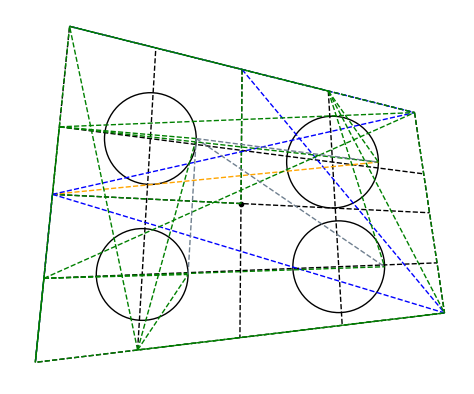

In [6]:
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')
datalib.render_sketch(sketch, ax)

SketchDataset.superimpose_constraints(sketch, ax)

fig.show()

In [9]:
def get_start_point(primitive):
    match primitive.type:
        case EntityType.Line:
            return torch.from_numpy(primitive.start_point)
        case EntityType.Circle:
            center = torch.from_numpy(primitive.center_point)
            center[0] += primitive.radius # add radius to x coord
            return center
        case EntityType.Arc:
            return torch.from_numpy(primitive.start_point)
        case EntityType.Point:
            return torch.Tensor([primitive.x, primitive.y])
        case _:
            return None
        
def get_end_point(primitive):
    match primitive.type:
        case EntityType.Line:
            return torch.from_numpy(primitive.end_point)
        case EntityType.Circle:
            center = torch.from_numpy(primitive.center_point)
            center[0] += primitive.radius # add radius to x coord
            return center
        case EntityType.Arc:
            return torch.from_numpy(primitive.end_point)
        case EntityType.Point:
            return torch.Tensor([primitive.x, primitive.y])
        case _:
            return None
        
def get_mid_point(primitive):
    match primitive.type:
        case EntityType.Line:
            return (torch.from_numpy(primitive.end_point) + torch.from_numpy(primitive.end_point)) / 2
        case EntityType.Circle:
            center = torch.from_numpy(primitive.center_point)
            center[0] -= primitive.radius # add radius to x coord
            return center
        case EntityType.Arc:
            return torch.from_numpy(primitive.mid_point)
        case EntityType.Point:
            return torch.Tensor([primitive.x, primitive.y])
        case _:
            return None

def superimpose_constraints(sketch, ax):
    for constraint in sketch.constraints.values():
        point1 = None
        point2 = None
        color = None
        #primitive1_idx = int(float(constraint.parameters[0].referenceMain)) + 1
        #print(sketch.entities[str(primitive1_idx)])
        prim1 = constraint.parameters[0].value.split('.')
        prim1_idx = prim1[0]
        prim1_sub = prim1[1] if len(prim1) > 1 else ''
        prim1_idx = str(int(prim1_idx) + 1)
        match prim1_sub:
            case "start":
                point1 = get_start_point(sketch.entities[prim1_idx])
            case "center":
                point1 = get_mid_point(sketch.entities[prim1_idx])
            case "end":
                point1 = get_end_point(sketch.entities[prim1_idx])
            case _:
                point1 = get_start_point(sketch.entities[prim1_idx])
        # print(constraint.parameters[0].value)
        if len(constraint.parameters) > 1:
            #primitive2_idx = int(float(constraint.parameters[1].referenceMain)) + 1
            #print(sketch.entities[str(primitive2_idx)])
            prim2 = constraint.parameters[1].value.split('.')
            prim2_idx = prim2[0]
            prim2_sub = prim2[1] if len(prim1) > 1 else ''
            prim2_idx = str(int(prim2_idx) + 1)
            match prim2_sub:
                case "start":
                    point2 = get_start_point(sketch.entities[prim2_idx])
                case "center":
                    point2 = get_mid_point(sketch.entities[prim2_idx])
                case "end":
                    point2 = get_end_point(sketch.entities[prim2_idx])
                case _:
                    point2 = get_start_point(sketch.entities[prim2_idx])
            # print(constraint.parameters[1].value)

        match constraint.type:
            case ConstraintType.Coincident:
                color = 'green'
            case ConstraintType.Horizontal:
                color = 'red'
            case ConstraintType.Vertical:
                color = 'brown'
            case ConstraintType.Parallel:
                color = 'pink'
            case ConstraintType.Perpendicular:
                color = 'purple'
            case ConstraintType.Tangent:
                color = 'orange'
            case ConstraintType.Midpoint:
                color = 'blue'
            case ConstraintType.Equal:
                color = 'slategrey'
            case _:
                continue
        ax.plot((point1[0], point2[0]), (point1[1], point2[1]), color, linestyle='--', linewidth=1, marker=None)
    return

In [1]:
import torch
from dataset1 import SketchDataset

In [2]:
dataset = SketchDataset(root = "data/")

In [16]:
from diffusion_model import GD3PM
import sys
import importlib
importlib.reload(sys.modules['diffusion_model'])

model = GD3PM(0)

In [17]:
nodes = dataset.nodes[0:4].to(0)
edges = dataset.edges[0:4].to(0)
params_mask = dataset.node_params_mask[0:4].to(0)

timestep = torch.randint(low = 1, high = model.max_steps, size = (4,), device = 0)
noisy_nodes, noisy_edges, true_noise = model.noise_scheduler(nodes, edges, timestep)
pred_nodes, pred_edges = model(noisy_nodes, noisy_edges, timestep)

: 